In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import copy
from pprint import pprint

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from models.pytorch_model import OrigamiNetwork
import matplotlib.pyplot as plt
import numpy as np
from vis_helpers import *
from jeffutils.utils import stack_trace, reimport
reimport('reimport model.pytorch_model OrigamiNetwork', globals())

In [25]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
iris = load_iris()
X = iris.data
y = iris.target

# Preprocess
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize and train model
model = OrigamiNetwork(n_layers=1, width=3, epochs=300,learning_rate = 0.01, optimizer_type = 'adam', lr_schedule=False)
model.fit(X_train, y_train, X_val, y_val)

#Evaluate on validation set
y_pred = model.predict(X_val)
test_accuracy = accuracy_score(y_val, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

/Users/jeddybennett/Documents/FoldAndCutNetworks/models/pytorch_model.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)
Val Accuracy: 0.9667: 100%|██████████| 300/300 [00:02<00:00, 134.48it/s]

Test Accuracy: 0.9667


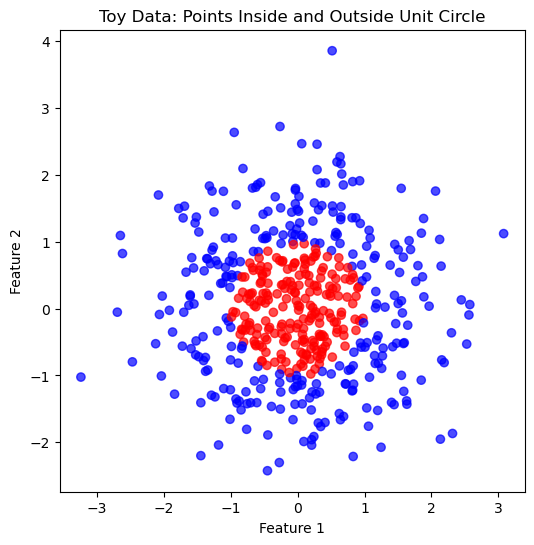

In [55]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 500

width = 2
# Generate random points in 2D space
X = np.random.randn(n_samples, width)

# Labels: Points inside the unit circle are labeled True (1), others False (0)
y = (np.linalg.norm(X, axis=1) < 1).astype(int)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.title('Toy Data: Points Inside and Outside Unit Circle')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis('equal')
plt.show()

In [56]:
# Split data: 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [57]:
layers = 8
model = OrigamiNetwork(
    n_layers=layers,
    width=2,
    epochs=1000,
    learning_rate=0.01,
    sigmoid=False,  # Set to True if you want to use the sigmoid fold
    crease=5,
    optimizer_type='sgd',  # Use 'sgd' or 'adam'
    batch_size=32,
    leak = 0.1,
    lr_schedule=False
)

In [2]:
def layer_sam(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    return D + mask[:,np.newaxis] * (2*n - (2 * np.outer(scales, n)))
fv1 = np.array([0,.5])
size = 10
X1, X2 = np.meshgrid(np.linspace(-2,2,size), np.linspace(-2,2,size))
sandwichX = np.concatenate((X1.reshape(-1,1), X2.reshape(-1,1)), axis=1)
sandwichY = layer_sam(sandwichX, fv1)[:,1] > -.5
# plt.scatter(sandwichX[:,0], sandwichX[:,1], c=sandwichY)
sandwichX = torch.tensor(sandwichX, dtype=torch.float32)
sandwichY = torch.tensor(sandwichY, dtype=torch.float32)

size = 30
x1 = np.linspace(-2,2,size)
x2 = np.linspace(-2,2,size)
X1,X2 = np.meshgrid(x1,x2)
xorX = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
xorY = np.array([[1 if (i < size//2 and j < size//2 or i >= size//2 and j >= size//2) else 0 for j in range(size)] for i in range(size)]).reshape(-1)
# plt.scatter(xorX[:,0], xorX[:,1], c=xorY)
xorX = torch.tensor(xorX, dtype=torch.float32)
xorY = torch.tensor(xorY, dtype=torch.float32)

count = 20
onedX = np.linspace(-2,2,count)
onedY = np.zeros(count)
onedY[:6] = 1
onedY[-6:] = 1
onedX = np.expand_dims(onedX, axis=1)
onedX = torch.tensor(onedX, dtype=torch.float32)
onedY = torch.tensor(onedY, dtype=torch.float32)

In [23]:
test_case_x = xorX
test_case_y = xorY
print("Testing xor problem")
layers = 4
test = OrigamiNetwork(n_layers=layers, width=None, epochs=300, 
                      learning_rate=0.01, optimizer_type="adam", crease=None)
test.load_data(test_case_x, test_case_y)
# test.set_folds([np.array([-0.00466453, 0.53786325])])
test.fit()
logits, out = test.forward(test_case_x, return_intermediate=True)

# print("\nScore =", test.score(), "after training")
print("Cut", test.get_cut_vector(), "Fold vectors", sep="\n")
pprint(test.get_fold_vectors())

Testing xor problem


Training: 100%|██████████| 300/300 [00:30<00:00,  9.95it/s]


Cut
[[-6.2373476  2.4744213]
 [ 5.3595834 -2.2907495]]
Fold vectors
{'Layer 0': {'crease': [0.332], 'hyperplane': [-0.039, -2.031]},
 'Layer 1': {'crease': [-5.888], 'hyperplane': [0.392, -0.398]},
 'Layer 2': {'crease': [-5.562], 'hyperplane': [-0.445, -0.48]},
 'Layer 3': {'crease': [-4.358], 'hyperplane': [-0.578, 0.096]}}


In [20]:
reimport("from vis_helpers import *", globals())
for l in range(layers):
    plot_wiggles(test.get_history("fold"), test.get_history("crease"), layer=l)

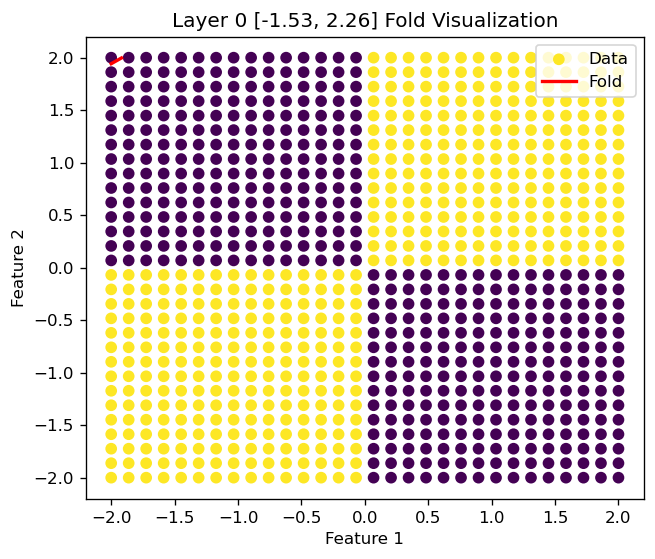

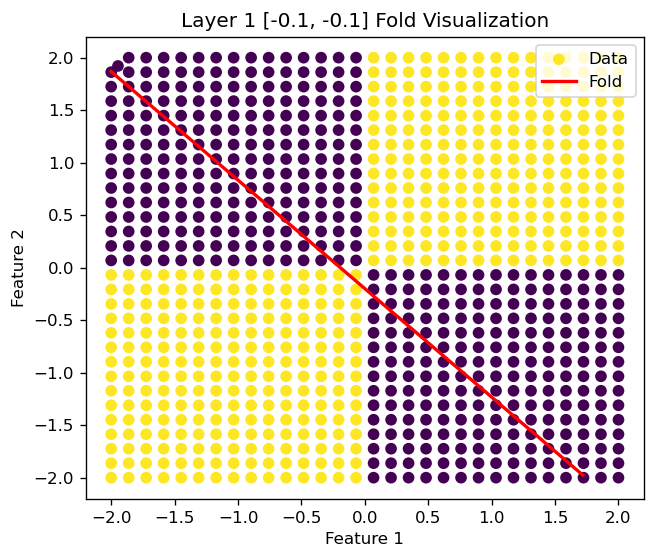

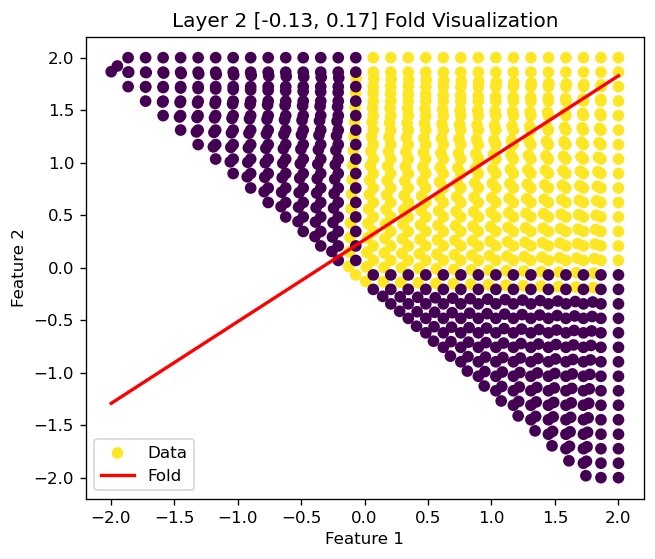

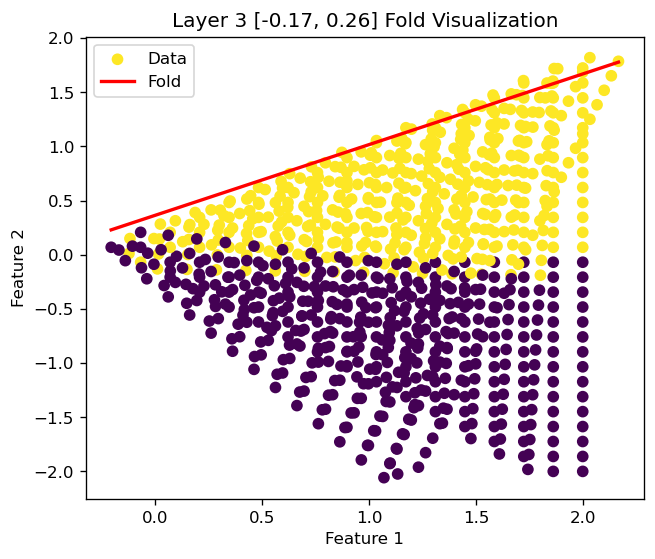

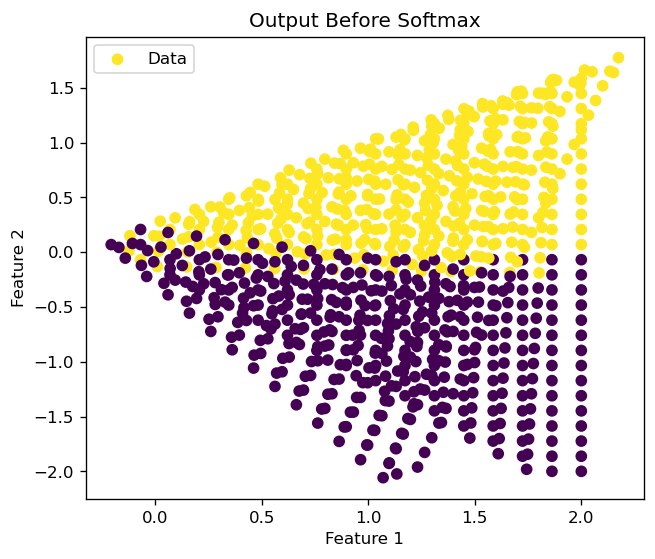

In [21]:
# Visualize folds at each layer
# reimport("from models.pytorch_model_old import OrigamiNetwork", globals())
# reimport("from vis_helpers import *", globals())
for layer_index in range(layers+1):
    plot_folds(test, layer_index=layer_index, use_plotly=False)

In [22]:
max_score, best_folds = create_landscape(test, landscape_type="Loss", show_layers=None, create_plot=True, density=61, verbose=1)

Loss Layer 0:   0%|          | 0/3721 [00:00<?, ?it/s]

Loss Layer 0:  50%|████▉     | 1860/3721 [00:01<00:01, 936.05it/s]


TypeError: cannot assign 'torch.FloatTensor' as parameter 'n' (torch.nn.Parameter or None expected)